# Final Project
Andrew Altomare

### Introduction

The need to solve systems of nonlinear equations arises often in the study of PDE's. A powerful and ubiquitous technique for doing so is given by Newton-type methods. Of particular appeal are Jacobian-free Newton-Krylov methods (JFNK), which achieve the superlinear convergence of traditional Newton-type methods but with a more parsimonious treatment of the Jacobian-vector product with respect to both memory and computation. Newton-type methods take the form
$$
\begin{align}
J(u_k)\delta u_k &= -F(u_k) \\
u_{k+1} &= u_k + \delta u_k
\end{align}
$$

for $k=0,1,2,...,$ where $F$ is a residual vector and $J$ is its Jacobian. In Newton-Krylov methods, the first equation is solved with a Krylov method like GMRES. As mentioned, approximating the Jacobian offers an attractive alternative to computing the actual Jacobian, which can be a convoluted and expensive operation. Here the action of the Jacobian is approximated with the formula

$$
Jv\approx (F(u+\epsilon v) - F(u)) / \epsilon
$$

### 1D Shallow Water Equations

The shallow water equations (SWE) comprise a system of hyperbolic PDE's for describing fluid flow below a pressure surface in a fluid when the horizontal length scale is much greater than the vertical length scale. SWE have surprisingly many applications, including modeling atmosphere, tsunami forecasting, river flooding, dam-break problems, and more. The one-dimensional verison is given below.

$$
\begin{align*}
\begin{bmatrix}h\\hu\end{bmatrix}_t + \begin{bmatrix}hu\\hu^2 + \frac{g}{2}h^2\end{bmatrix}_x &= 0 \\
\end{align*}
$$

In this project, a finite volume method is used to discretize the spatial dimension. Below is a solution of the SWE with a Runge-Kutta 4 time integrator. Solution is plotted in the following figures.

In [136]:
def limit_vl(r):
    return numpy.maximum(4*r*(1-r), 0)

def rk_butcher_4():
    A = numpy.array([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]])
    b = numpy.array([1/6, 1/3, 1/3, 1/6])
    return A, b

def ode_rkexplicit(f, u0, butcher=None, tfinal=1, h=.1):
    if butcher is None:
        A, b = rk_butcher_4()
    else:
        A, b = butcher
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        u += h * fY @ b
        t = tnext
        hist.append((t, u.copy()))
    return hist

In [137]:
import numpy
from matplotlib import pyplot
import scipy.sparse.linalg as splinalg

def flux_shallow(w, g=9.81):
    h = w[0]
    u = w[1] / h
    return array([w[1], w[1]*u + 0.5*g*h**2])

def riemann_shallow(UL, UR, c, maxit=20):
    rhoL = UL[0]
    rhoR = UR[0]
    uL = UL[1] / rhoL
    uR = UR[1] / rhoR
    rho = .5*(rhoL + rhoR)  # Initial guess to Newton solve
    for i in range(maxit):
        ujumpL = numpy.where(rho > rhoL,
                            (rhoL - rho) / numpy.sqrt(rho*rhoL),    # shock
                            c * (numpy.log(rhoL) - numpy.log(rho))) # rarefaction
        ujumpR = numpy.where(rho > rhoR,
                            (rhoR - rho) / numpy.sqrt(rho*rhoR),    # shock
                            c * (numpy.log(rhoR) - numpy.log(rho))) # rarefaction
        residual = ujumpL + ujumpR - (uR - uL)
        # print('{: 2d} {:10.2e} {:5f} {:5f}'.format(i, numpy.linalg.norm(residual), min(rho), max(rho)))
        if numpy.linalg.norm(residual) < 1e-10:
            u = uL + ujumpL
            break
        elif i+1 == maxit:
            raise RuntimeError('Newton solver failed to converge')
        dujumpL = numpy.where(rho > rhoL,
                             -(1 + .5*(rhoL - rho)/rho)/numpy.sqrt(rho*rhoL), # shock
                              -c / rho)                                       # rarefaction
        dujumpR = numpy.where(rho > rhoR,
                             -(1 + .5*(rhoR - rho)/rho)/numpy.sqrt(rho*rhoR), # shock
                              -c / rho)                                       # rarefaction
        delta_rho = -residual / (dujumpL + dujumpR)
        while min(rho + delta_rho) <= 0:  # line search to prevent negative density
            delta_rho *= .5
        rho += delta_rho
    U0 = numpy.zeros_like(UL)
    for i in range(len(rho)):
        if uL[i] - c < 0 < u[i] - c or u[i] + c < 0 < uR[i] + c:
            # Inside left (right) sonic rarefaction
            U0[0,i] = numpy.exp(-(u[i] - numpy.sign(u[i])*c - c*numpy.log(rho[i]))/c)
            U0[1,i] = U0[0,i] * numpy.sign(u[i])*c
        elif ((rhoL[i] >= rho[i] and 0 <= uL[i] - c) or
              (rhoL[i] < rho[i] and 0 < (rho[i]*u[i] - UL[1,i]))):
            # Left rarefaction or shock is supersonic
            U0[:,i] = UL[:,i]
        elif ((rhoR[i] >= rho[i] and uR[i] + c <= 0) or
              (rhoR[i] < rho[i] and UR[1][i] - rho[i]*u[i]) > 0):
            # Right rarefaction or shock is supersonic
            U0[:,i] = UR[:,i]
        else:
            # Sample star state
            U0[0,i] = rho[i]
            U0[1,i] = rho[i]*u[i]
    return flux_shallow(U0, c)

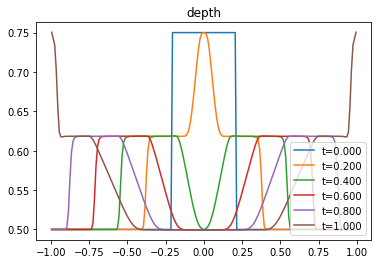

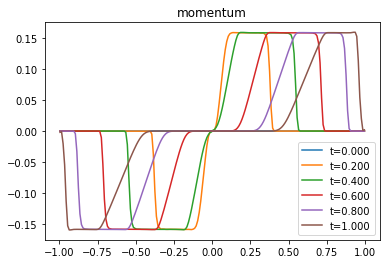

In [174]:
def fvsolve2system(riemann, U0, a=-1, b=1, n=20, tfinal=1, limit=limit_minmod, args = ()):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        fluxL = riemann(U[:,idxL] + g[:,idxL] * h/2, U - g * h/2, *args)
        return (fluxL - fluxL[:,idxR]).flatten() / h 
    hist = ode_rkexplicit(rhs, U0x.flatten(), h=h/2, tfinal=tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

def initial_shallow(x):
    return numpy.array([0.5 + 0.25*(numpy.exp(-(x*4)**2)>.5), 0*x])
#     return numpy.array([0*x+1, 0*x])

x, hist = fvsolve2system(riemann_shallow, initial_shallow, n=200, limit=limit_vl, args=(1,))
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.title('depth')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.title('momentum')
pyplot.legend(loc='lower right');

## Jacobian Free Newton Krylov Methods


### Backwards Euler

Consider again the SWE

$$
\begin{align*}
\frac{\partial h}{\partial t} &+ \frac{\partial hu}{\partial x} = 0 \\
\frac{\partial hu}{\partial t} &+ \frac{\partial}{\partial x}(hu^2 + \frac{g}{2}h^2) = 0
\end{align*}
$$

We can discretize in time to get

$$
\begin{align*}
\frac{h_{t} - h_{t+\Delta t}}{\Delta t} &+ \frac{\partial}{\partial x}(hu) = 0 \\
\frac{hu_t - hu_{t+\Delta t}}{\Delta t} &+ \frac{\partial}{\partial x}(hu^2 + \frac{g}{2}h^2) = 0
\end{align*}
$$

Backwards Euler follows by evaluating the spatial derivatives at the "next" time step:

$$
\begin{align*}
h_{t+\Delta t} &= h_{t} + \Delta t \frac{\partial}{\partial x}(hu_{t+\Delta t}) \\
hu_{t+\Delta t} &= hu_{t} + \Delta t \frac{\partial}{\partial x}(hu^2_{t+\Delta t} + \frac{g}{2}h_{t+\Delta t}^2)
\end{align*}
$$

Below we solve these equations with a JFNK method with the GMRES Krylov solver. The Newton convergence is shown for the first time step.

Newton 0 anorm 2.47e-02 rnorm 3.36e-01
Newton 1 anorm 4.19e-03 rnorm 5.70e-02
Newton 2 anorm 1.45e-05 rnorm 1.97e-04
Newton 3 anorm 6.87e-07 rnorm 9.35e-06
Newton 4 anorm 2.30e-07 rnorm 3.12e-06
Newton 5 anorm 7.12e-08 rnorm 9.68e-07
Newton 6 anorm 1.91e-08 rnorm 2.60e-07
Newton 7 anorm 5.34e-09 rnorm 7.26e-08
Newton 8 anorm 1.91e-09 rnorm 2.60e-08
Newton 9 anorm 6.80e-10 rnorm 9.24e-09
Newton 10 anorm 2.02e-10 rnorm 2.75e-09
Newton 11 anorm 5.39e-11 rnorm 7.33e-10
Newton 12 anorm 2.06e-11 rnorm 2.80e-10
Newton 13 anorm 6.95e-12 rnorm 9.45e-11


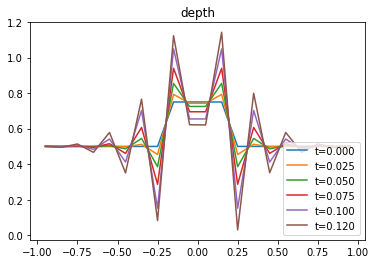

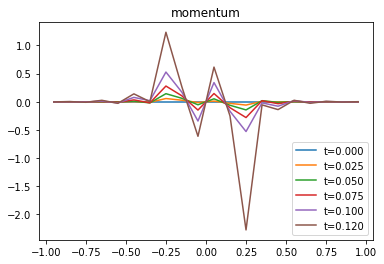

In [187]:
def newton_krylov(F, u0, h, tfinal, maxit=50, eps=1e-8, rtol=1e-10, verbose=True):
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        # NK method starts here
        Fu = h*F(t, u)
        norm0 = numpy.linalg.norm(Fu)
        norm = norm0
        ulast = u.copy()
        for i in range(maxit): # newton loop
            def F_t(u):
                return u - ulast + h*F(t, u)
            def Ju_fd(v):
                return (F_t(u + eps*v) - Fu) / eps
            Ju = splinalg.LinearOperator((len(Fu),len(u)), matvec=Ju_fd)
#             M = numpy.eye(len(u))
            du, info = splinalg.gmres(Ju, Fu, atol=1.e-6, maxiter=500)
            if info != 0:
                print(numpy.linalg.norm(Ju @ du - Fu), norm)
                raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
            u -= du
            Fu = F_t(u)
            norm = numpy.linalg.norm(Fu)
            if verbose and t==0:
                print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'
                      .format(i, norm, norm/norm0))
            if norm < rtol * norm0:
                break
        t = tnext
        hist.append((t, u.copy()))
    return hist

def fvsolve2system(riemann, U0, a=-1, b=1, n=20, tfinal=.12, limit=limit_minmod, args = ()):
    h = (b - a)/n
    x = numpy.linspace(a+h/2, b-h/2, n) # Element midpoints (centroids)
    U0x = U0(x)
    Ushape = U0x.shape
    idxL = numpy.arange(-1, n-1)
    idxR = numpy.arange(1, n+1) % n
    def rhs(t, U):
        U = U.reshape(Ushape)
        jump = U[:,idxR] - U[:,idxL]
        r = numpy.zeros_like(jump)
        numpy.divide(U - U[:,idxL], jump, out=r, where=(jump!=0))
        g = limit(r) * jump / (2*h)
        fluxL = riemann(U[:,idxL] + g[:,idxL] * h/2, U - g * h/2, *args)
        return (fluxL - fluxL[:,idxR]).flatten() / h 
#     hist = ode_rkexplicit(rhs, U0x.flatten(), h=h/2, tfinal=tfinal)
    hist = newton_krylov(rhs, U0x.flatten(), h/4., tfinal)
    return x, [(t, U.reshape(Ushape)) for t, U in hist]

x, hist = fvsolve2system(riemann_shallow, initial_shallow, n=20, limit=limit_vl, args=(1,))
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[0], label='t={:.3f}'.format(t))
pyplot.title('depth')
pyplot.legend(loc='lower right');
pyplot.figure()
for t, U in hist[::len(hist)//5]:
    pyplot.plot(x, U[1]/U[0], label='t={:.3f}'.format(t))
pyplot.title('momentum')
pyplot.legend(loc='lower right');

This method was very sensitive to initial conditions, and demanded a much smaller timestep than the RK method above, which is troubling because implicit methods can usually get away with longer time steps. Also, I was not able to configure it to converge for long time periods. I suspect this is due to the stability issues of the Implicit Euler method.

### Preconditioning

Often the success of a Newton-Krylov method hinges on the efficiency of the linear Krylov solver. To the end of improving efficacy of these solvers, nothing pays dividends like the perfect preconditioner. Preconditioning is about clustering the spectrum of the operator (here the Jacobian); this is accomplished by employing some cheap approximation of its inverse. Most standard preconditioners are constructed based on clever factorizations of the linear operator. With JFNK methods though, we do not have direct access to the Jacobian, so incomplete Cholesky, incomplete LU, SOR, SSOR, etc. are not viable techniques.

Physics-based preconditioners provide an interesting option. Solving some linearized version of the problem, or using some cheap legacy method for solving the problem provides a natural preconditioner to the Jacobian. Although I was unable to overcome issues with the Newton-Krylov solver on implicit Euler, and thus unable to produce a comparison of different preconditioning techniques, I am excited by one particular approach outlined by Knoll et al. in several papers, which involves the simple linearization and time splitting method below

$$
\begin{align*}
\frac{h_{t+\Delta t}-h_t}{\Delta t} - \frac{\partial}{\partial x}\left( \Delta tgh_t\frac{\partial h_{t+\Delta t}}{\partial x} \right) = \frac{\partial}{\partial x}\left( uh_t - \Delta t\frac{\partial (u^2h)_t}{\partial x} \right)
\end{align*}
$$

solving for $h_{t+\Delta t}$ then substituting into the following equation to get $hu_{t+\Delta t}$:

$$
hu_{t+\Delta t} = -\Delta tgh_t\frac{\partial h_{t+\Delta t}}{\partial x} + uh_t - \Delta t\frac{\partial(u^2h)_t}{\partial x}
$$

This of course does not require formation of the Jacobian so it is viable for JFNK.

### References

1. J. Hudson, “Numerical Techniques for the Shallow Water Equations.” [Online]. Available: https://www.reading.ac.uk/web/files/maths/02-99.pdf. 

2. D. A. Knoll, L. Chacon, L. G. Margolin, and V. A. Mousseau, “On balanced approximations for time integration of multiple time scale systems,” Science Direct. [Online]. Available: https://www.ldeo.columbia.edu/~mspieg/e4301/Reading/KnollChaconMargolinMousseau-OnBalancedApproximationsTimeIntegrationMultipleTimeScaleSystems-2003.pdf. 

3. D. A. Knoll, V. A. Mousseau, L. Chacon, and J. Reisner, “Jacobian-Free Newton-Krylov Methods for the Accurate Time Integration of Stiff Wave Systems.” [Online]. Available: https://link.springer.com/content/pdf/10.1007/BF02728989.pdf. 

4. D. A. Knoll and D. E. Keyes, “Jacobian-free Newton-Krylov methods: a survey of approaches and applications,” Science Direct. [Online]. Available: https://www.cs.odu.edu/~keyes/papers/jfnk.pdf. 

5. “Lax–Friedrichs method,” Wikipedia, 03-Dec-2018. [Online]. Available: https://en.wikipedia.org/wiki/Lax–Friedrichs_method. [Accessed: 19-Dec-2018]. 

6. V. A. Mousseau, D. A. Knoll, and J. M. Reisner, “An Implicit Nonlinearly Consistent Method for the Two-Dimensional Shallow-Water Equations with Coriolis Force.” [Online]. Available: https://journals.ametsoc.org/doi/pdf/10.1175/1520-0493(2002)130<2611:AINCMF>2.0.CO;2.

7. S. Mungkasi and J. Sihotang, “A Modified Newton's Method Used to Solve a Steady Flow Problem Based on the Shallow Water Equations.” [Online]. Available: https://aip.scitation.org/doi/pdf/10.1063/1.4968259?class=pdf.